# **`Anti Discrimination Project`**
*Done By Paramesh E*
#### Background:
Anti-discrimination behavioral analysis in airlines involves analyzing staff interactions with passengers to detect potential discriminatory behavior based on body language, tone of voice, and facial expressions. Monitoring complaints and feedback from passengers can also help identify patterns of discrimination and alert management for corrective action, ultimately promoting a more inclusive environment and improving the overall passenger experience.



In [294]:
# Connecting drive
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## **Data Reading and Understanding**

### **Importing libraries**

In [295]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import pickle
import pandas as pd
# for PREPROCESSING
import re    # RegEx for removing non-letter characters
import nltk  # natural language tool kit
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem.porter import *
from keras.preprocessing.text import Tokenizer


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [296]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [297]:
pip install emoji --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [298]:
pip install emoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [299]:
import emoji

In [300]:
# Load the dataset
tweet_data = pd.read_csv('/content/drive/MyDrive/Tweets.csv')

In [301]:
tweet_data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials to the experience... tacky.,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I need to take another trip!,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &...",NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing about it,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [302]:
print(tweet_data.shape)

(14640, 15)


In [303]:
tweet_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [304]:
tweet_data.dtypes

tweet_id                          int64
airline_sentiment                object
airline_sentiment_confidence    float64
negativereason                   object
negativereason_confidence       float64
airline                          object
airline_sentiment_gold           object
name                             object
negativereason_gold              object
retweet_count                     int64
text                             object
tweet_coord                      object
tweet_created                    object
tweet_location                   object
user_timezone                    object
dtype: object

In [305]:
tweet_data.duplicated().sum()

36

In [306]:
# There are 36 duplicate rows
# Drop the duplicate rows
tweet_data.drop_duplicates(keep=False,inplace=True)

In [307]:
print(tweet_data.shape)

(14568, 15)


In [308]:
tweet_data.describe()

,tweet_id,airline_sentiment_confidence,negativereason_confidence,retweet_count
count,1.456800e+04,14568.000000,10484.000000,14568.000000
mean,5.692131e+17,0.899675,0.636987,0.082921
std,7.773880e+14,0.163080,0.330318,0.747520
min,5.675883e+17,0.335000,0.000000,0.000000
25%,5.685551e+17,0.691975,0.360300,0.000000
50%,5.694655e+17,1.000000,0.670400,0.000000
75%,5.698859e+17,1.000000,1.000000,0.000000
max,5.703106e+17,1.000000,1.000000,44.000000


In [309]:
# Check the most common negative reason 
counts = tweet_data['negativereason'].value_counts().reset_index()
counts_df = pd.DataFrame(counts)
print(counts_df)

                         index  negativereason
0       Customer Service Issue            2898
1                  Late Flight            1655
2                   Can't Tell            1190
3             Cancelled Flight             839
4                 Lost Luggage             718
5                   Bad Flight             580
6      Flight Booking Problems             529
7  Flight Attendant Complaints             479
8                    longlines             178
9              Damaged Luggage              74


In [310]:
counts_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   index           10 non-null     object
 1   negativereason  10 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 288.0+ bytes


<BarContainer object of 10 artists>

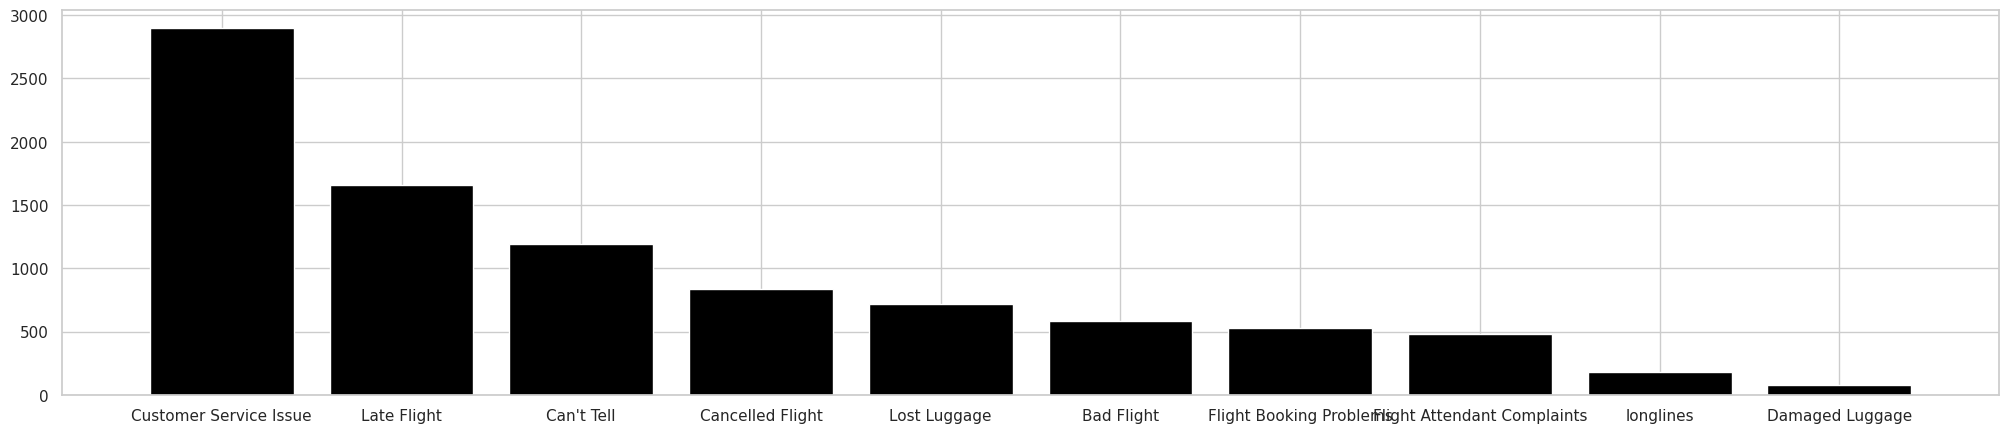

In [311]:
plt.figure(figsize=(25,5)) 
plt.bar(counts['index'], counts['negativereason'], color = 'black' )

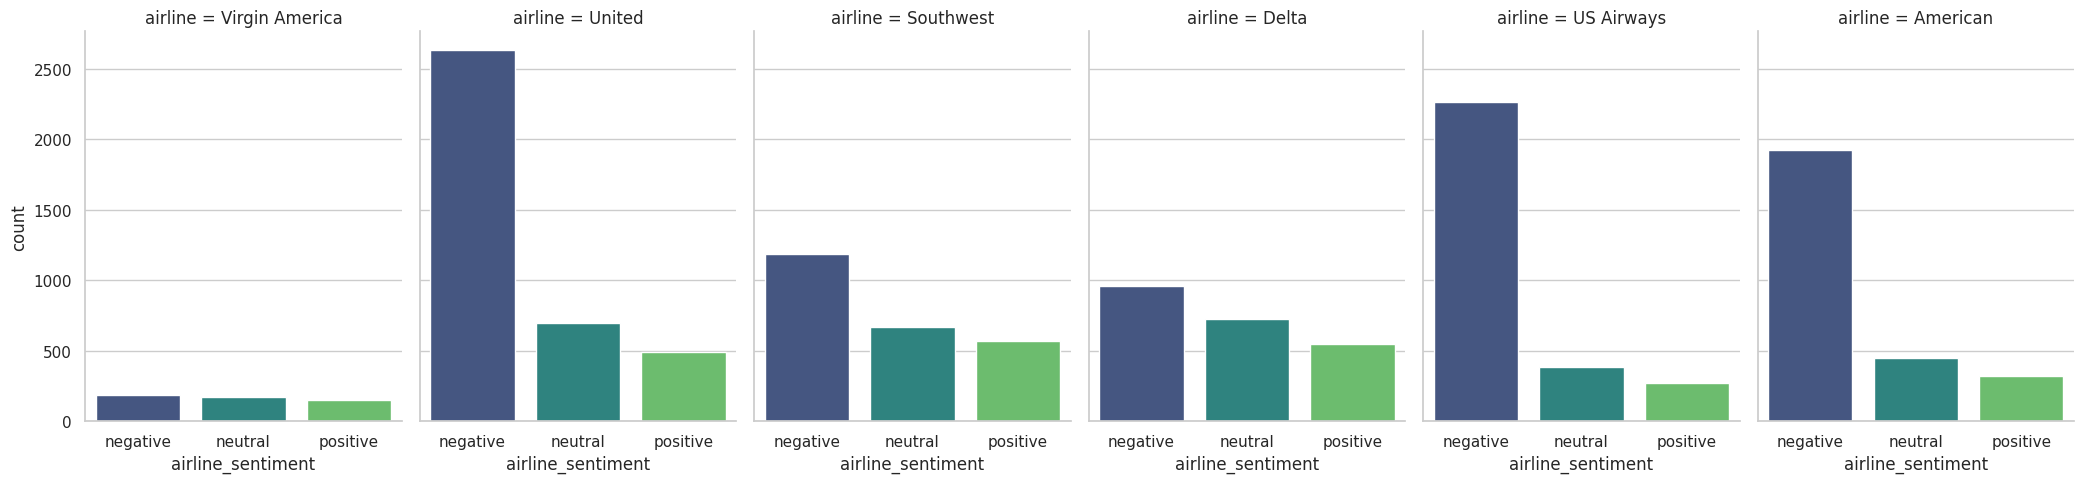

In [312]:
g = sns.FacetGrid(tweet_data, col="airline", height=5, aspect =0.7)
g = g.map(sns.countplot, "airline_sentiment", order =tweet_data.airline_sentiment.value_counts().index, palette='viridis' )
plt.show()
# Here we can see that United Airlines, US Airways, American Airlines has the most number of negative review
# Virgin America has the least number of negative reviews

**Most Common negative review reasons**
*   There are 14640 rows and 15 columns in the tweet data
*   There are 36 duplicate records in the data set
*   Here we can see that United Airlines, US Airways, American Airlines has the most number of negative review
*   Virgin America has the least number of negative reviews
*   Customer service and Late flight seems to be the main reason why customers are giving bad feedback



###**Data Cleaning**

**Understand of data-columns:**

a. Drop all other columns except “text” and “airline_sentiment”. 

b. Check the shape of data. 

c. Print first 5 rows of data. 

**Drop Irrelevant columns**

In [313]:
# Let us now remove irrelevant columns
df_tweets_air = tweet_data[["text", "airline_sentiment"]]

**Shape of Data**

In [314]:
# There are 14568 rows and 2 columns (This is result of keeping relevant rows and duplicate data cleanup)
df_tweets_air.shape

(14568, 2)

In [315]:
df_tweets_air = df_tweets_air.rename(columns = {"text": "text", "airline_sentiment": "category"})

In [316]:
df_tweets_air["category"] = df_tweets_air["category"].map({"negative": -1.0, "neutral": 0.0, "positive": 1.0})

In [317]:
df_tweets_air.head()

,text,category
0,@VirginAmerica What @dhepburn said.,0.0
1,@VirginAmerica plus you've added commercials to the experience... tacky.,1.0
2,@VirginAmerica I didn't today... Must mean I need to take another trip!,0.0
3,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &...",-1.0
4,@VirginAmerica and it's a really big bad thing about it,-1.0


In [318]:
df_tweets_air.isnull().sum()

text        0
category    0
dtype: int64

In [319]:
def remove_emojis(text_import):
    regex_pattern = re.compile(pattern="["
                                        u"\U0001F600-\U0001F64F"  # emoticons
                                        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                        u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                        u"\U00002702-\U000027B0"
                                        u"\U00002702-\U000027B0"
                                        u"\U000024C2-\U0001F251"
                                        u"\U0001f926-\U0001f937"
                                        u"\U00010000-\U0010ffff"
                                        u"\u2640-\u2642"
                                        u"\u2600-\u2B55"
                                        u"\u200d"
                                        u"\u23cf"
                                        u"\u23e9"
                                        u"\u231a"
                                        u"\ufe0f"  # dingbats
                                        u"\u3030"
                                        "]+", flags=re.UNICODE)
    return regex_pattern.sub(" ", text_import)

In [320]:
# Define regular expression to match emojis
emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)

# Remove emojis from 'text' column
df_tweets_air['text'] = df_tweets_air['text'].apply(lambda x: emoji_pattern.sub(r'', x))

In [321]:
# importing libraries
from nltk import FreqDist
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
import re
pd.set_option('max_colwidth', 100)
from sklearn.feature_extraction.text import TfidfVectorizer

In [322]:
# intialsing package punkt
import nltk 
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [323]:
# intialsing package wordnet
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [324]:
# intialsing package Open Multilingual Wordnet
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [325]:
# Intialising stopwords
import nltk
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [326]:
# Defining preprocess function
stemmer = PorterStemmer()
wordnet_lemmatizer = WordNetLemmatizer()
def preprocess(document):
    
    # change sentence to lower case
    document = document.lower()

       
    # tokenize into words
    words = word_tokenize(document)

    # remove stop words
    words = [word for word in words if word not in stop_words]
    
    
    # take only thos words whose length is greater than 2
    words=[w for w in words if len(w)>2]
    
    # join words to make sentence
    document = " ".join(words)
    
    return document

In [327]:
# Defining remove_words function
def remove_words(document):
   # tokenize into words
    words = word_tokenize(document)

    # remove positive/negative words
    words = [word for word in words if word not in positive_words]
    words = [word for word in words if word not in negative_words]
    
    document = " ".join(words)
    
    return document

In [328]:
# defining remove_punctuations function
def remove_punctuations(text):
    text = re.sub('[^A-Za-z]+', ' ', text)
    
    return text

In [329]:
# defining apply_lemmatization function
stemmer = PorterStemmer()
wordnet_lemmatizer = WordNetLemmatizer()
def apply_lemmatization(document):
     # tokenize into words
         # change sentence to lower case
    document = document.lower()
    words = word_tokenize(document)

    # remove stop words
    words = [word for word in words if word not in stop_words]
    
    #apply lemmatization
    words = [wordnet_lemmatizer.lemmatize(word, pos='v') for word in words]

    words=[w for w in words if len(w)>2]
    
    # join words to make sentence
    document = " ".join(words)
    
    return document

In [330]:
# Preprocessing reviewText column
df_sentiment["review_text_nostop"]=[preprocess(x) for x in df_sentiment["text"]]

In [331]:
# removing punctuations from the review_text_nostop column
df_sentiment["review_text_nostop"] = df_sentiment['review_text_nostop'].apply(remove_punctuations)

In [332]:
# after removing punctuation marks still there are some stop words so running above function to remove remaining stopwords and do lemmatization.
df_sentiment["review_text_nostop"]=[apply_lemmatization(x) for x in df_sentiment["review_text_nostop"]]


# `Building an engine for sentiment classification based on the sentiment of the text`
*   **Model building**
*   **evaluating**

In [333]:
# importing libraries
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import FreqDist
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")
%matplotlib inline
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report 
from mlxtend.plotting import plot_confusion_matrix

# setting output options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# filter warnings
import warnings
warnings.filterwarnings('ignore')

In [334]:
df_sentiment.head()

,text,category,review_text_nostop
0,@VirginAmerica What @dhepburn said.,0.0,virginamerica dhepburn say
1,@VirginAmerica plus you've added commercials to the experience... tacky.,1.0,virginamerica plus add commercials experience tacky
2,@VirginAmerica I didn't today... Must mean I need to take another trip!,0.0,virginamerica today must mean need take another trip
3,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &...",-1.0,virginamerica really aggressive blast obnoxious entertainment guests face amp little recourse
4,@VirginAmerica and it's a really big bad thing about it,-1.0,virginamerica really big bad thing


In [335]:
# Extracting columns
reviews_frame = df_sentiment[["review_text_nostop","category"]]

In [336]:
reviews_frame = reviews_frame.rename(columns={'review_text_nostop': 'reviewText', 'category': 'review_sentiment'})

In [337]:
reviews_frame.head()

,reviewText,review_sentiment
0,virginamerica dhepburn say,0.0
1,virginamerica plus add commercials experience tacky,1.0
2,virginamerica today must mean need take another trip,0.0
3,virginamerica really aggressive blast obnoxious entertainment guests face amp little recourse,-1.0
4,virginamerica really big bad thing,-1.0


#### Preprocess the text

In [338]:
# remove contraction and make it as normal string 
contractionsMain = {"ain't": "is not", "aren't": "are not","can't": "can not", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}

def getcontractions(contractionsMain):
    contraction_key = re.compile('(%s)' % '|'.join(contractionsMain.keys()))
    return contractionsMain, contraction_key

contractions, contraction_key = getcontractions(contractionsMain)
def replacecontractions(text):
    def replace(match):
        return contractions[match.group(0)]
    return contraction_key.sub(replace, text)

In [339]:
# function to remove punctuations
def text_purifier(text):
    text = re.sub('[^A-Za-z]+', ' ', text)
    text = text.lower()                             # convert text lower case
    text = re.sub(r"http\S+", "", text)             # text remove hyperlinks
    text = re.sub(r"#", "", text)                   # text remove hashtag symbol
    text = re.sub(r"@\S+", "", text)                # text remove @mentions
    text = ''.join((char for char in text
                    if not char.isdigit()))         # remove all numbers
    text = re.sub(r"'", "", text)                   # remove apostrophes
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)       # remove non letters
    text = re.sub(r"^RT[\s]+", "", text)            # remove retweet text "RT"

    
    return text

In [340]:
#function to remove numbers and punctuation marks
puncts_list=['!','@','#','$','%','^','&','*','(',')','-','_','+','=','{','}','[',']',':',';','?','/','\\','|','.','<','>']
def removepuctuationmarks(x):
    x = str(x)
    for punct in puncts_list:
        if punct in x:
            x = x.replace(punct, '')
    return x


In [341]:
# replace charachter appearing for more than twice in any word to single character 
def replace_multiple_characters(text):
        #repeat_pattern = re.compile(r'(\w)\1*')
        repeat_pattern = re.compile(r'(\w)\1{2,}')
        match_substitution = r'\1\1' 
        new_word = repeat_pattern.sub(match_substitution,text) 
        repeat_pattern1 = re.compile(r'(\w)\1{1,}$')
        match_substitution1 = r'\1' 
        new_word = repeat_pattern1.sub(match_substitution1,new_word) 
        return new_word
   

In [342]:
stemmer = PorterStemmer()
wordnet_lemmatizer = WordNetLemmatizer()
def preprocessText(document):
     # tokenize into idioms
         # change sentence to lower case
    document = document.lower()
    idioms = word_tokenize(document)
    # remove contractions
    idioms = [ replacecontractions(word) for word in idioms ]
    
    # remove stop idioms
    idioms = [word for word in idioms if word not in stop_words]
    
    # remove punctuation marks
    
    idioms=[text_purifier(word) for word in idioms]
    
    idioms=[replace_multiple_characters(word) for word in idioms]
    
    # remove stop idioms
    idioms = [word for word in idioms if word not in stop_words]
    
    #apply lemmatization
    idioms = [wordnet_lemmatizer.lemmatize(word, pos='v') for word in idioms]

    idioms=[word for word in idioms if len(word)>2]
    # join idioms to make sentence
    document = " ".join(idioms)
    
    return document

In [343]:
reviews_frame["reviewText"]=[preprocessText(str(x)) for x in reviews_frame["reviewText"]]

In [344]:
# convert to X and y
X = reviews_frame.reviewText
y = reviews_frame.review_sentiment
print(X.shape)
print(y.shape)

(14568,)
(14568,)


In [345]:
# splitting into test and train
from sklearn.model_selection  import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [346]:
X_train.head()

14487    americanair also reservations team fault bad top decision feel bad reservations social media team
2005                                                           unite weight restriction try get many plane
9588                                                                                       usairways thank
11960                             americanair worst company ever please fly repeat please fly credit delay
3709                                                unite patient let string tweet show people bad busines
Name: reviewText, dtype: object

In [347]:
y_train.head()

14487   -1.0
2005    -1.0
9588     1.0
11960   -1.0
3709    -1.0
Name: review_sentiment, dtype: float64

In [348]:
# vectorizing the sentences
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()

In [349]:
vect.fit(X_train)

CountVectorizer()

In [350]:
# printing the vocabulary
vect.vocabulary_

{'americanair': 290,
 'also': 262,
 'reservations': 6861,
 'team': 8031,
 'fault': 2855,
 'bad': 637,
 'top': 8305,
 'decision': 1993,
 'feel': 2882,
 'social': 7554,
 'media': 5104,
 'unite': 8608,
 'weight': 9010,
 'restriction': 6887,
 'try': 8425,
 'get': 3306,
 'many': 5007,
 'plane': 6222,
 'usairways': 8713,
 'thank': 8100,
 'worst': 9191,
 'company': 1577,
 'ever': 2699,
 'please': 6244,
 'fly': 3027,
 'repeat': 6822,
 'credit': 1807,
 'delay': 2027,
 'patient': 6054,
 'let': 4698,
 'string': 7794,
 'tweet': 8467,
 'show': 7376,
 'people': 6108,
 'busines': 1086,
 'check': 1336,
 'everyone': 2704,
 'board': 903,
 'pis': 6201,
 'always': 272,
 'good': 3401,
 'follow': 3071,
 'hope': 3766,
 'last': 4614,
 'speak': 7624,
 'baggage': 654,
 'sure': 7884,
 'city': 1417,
 'bag': 651,
 'southwestair': 7603,
 'twitter': 8474,
 'say': 7165,
 'someone': 7571,
 'unles': 8632,
 'jetblue': 4307,
 'april': 426,
 'anything': 380,
 'specific': 7630,
 'know': 4537,
 'first': 2951,
 'flight': 298

In [351]:
# vocab size
len(vect.vocabulary_.keys())

9445

In [352]:
# transforming the train and test datasets
X_train_transformed = vect.transform(X_train)
X_test_transformed = vect.transform(X_test)

In [353]:
# note that the type is transformed (sparse) matrix
print(type(X_train_transformed))
print(X_train_transformed)

<class 'scipy.sparse._csr.csr_matrix'>
  (0, 262)	1
  (0, 290)	1
  (0, 637)	2
  (0, 1993)	1
  (0, 2855)	1
  (0, 2882)	1
  (0, 5104)	1
  (0, 6861)	2
  (0, 7554)	1
  (0, 8031)	2
  (0, 8305)	1
  (1, 3306)	1
  (1, 5007)	1
  (1, 6222)	1
  (1, 6887)	1
  (1, 8425)	1
  (1, 8608)	1
  (1, 9010)	1
  (2, 8100)	1
  (2, 8713)	1
  (3, 290)	1
  (3, 1577)	1
  (3, 1807)	1
  (3, 2027)	1
  (3, 2699)	1
  :	:
  (10923, 3228)	1
  (10923, 5220)	1
  (10923, 5880)	1
  (10923, 6718)	1
  (10923, 7638)	1
  (10923, 8006)	1
  (10923, 8224)	1
  (10924, 1041)	1
  (10924, 2370)	1
  (10924, 2690)	1
  (10924, 2989)	1
  (10924, 3106)	1
  (10924, 3306)	1
  (10924, 3742)	1
  (10924, 4834)	1
  (10924, 5199)	1
  (10924, 5912)	1
  (10924, 7572)	1
  (10924, 8291)	1
  (10924, 8863)	1
  (10924, 8972)	1
  (10925, 290)	1
  (10925, 4560)	1
  (10925, 5089)	1
  (10925, 6860)	1


##  Building and Evaluating the Model

In [354]:
# training the NB model and making predictions
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()

# fit
mnb.fit(X_train_transformed,y_train)

# predict class
y_pred_class = mnb.predict(X_test_transformed)

# predict probabilities
y_pred_proba = mnb.predict_proba(X_test_transformed)


In [355]:
# printing  accuracy on train dataset
from sklearn import metrics
y_pred_train = mnb.predict(X_train_transformed)

print ("Accuracy on train dataset :")
metrics.accuracy_score( y_train, y_pred_train)

Accuracy on train dataset :


0.8329672341204466

In [356]:
print(metrics.classification_report(y_train,y_pred_train))

              precision    recall  f1-score   support

        -1.0       0.82      0.97      0.89      6875
         0.0       0.84      0.53      0.65      2306
         1.0       0.87      0.70      0.78      1745

    accuracy                           0.83     10926
   macro avg       0.85      0.73      0.77     10926
weighted avg       0.84      0.83      0.82     10926



<Figure size 640x480 with 0 Axes>

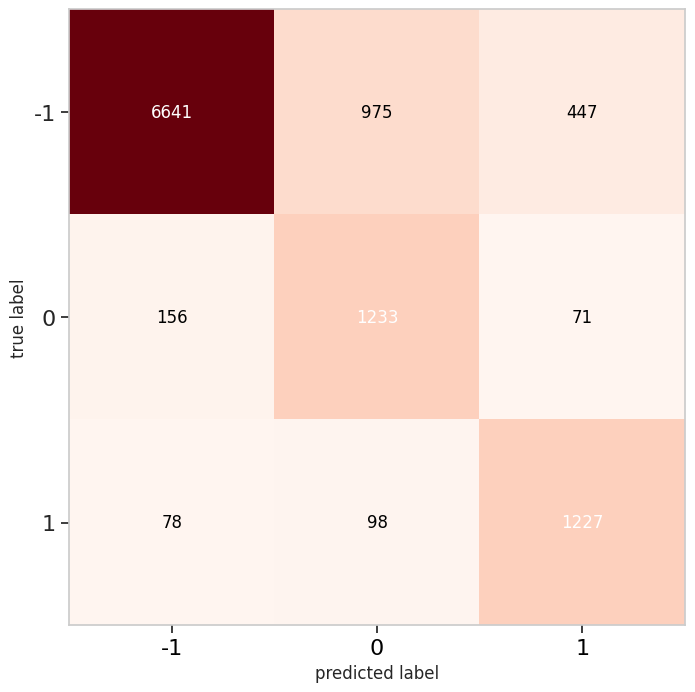

In [357]:
cm=confusion_matrix(y_pred_train , y_train)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Reds)
plt.xticks(range(3), [-1, 0, 1], fontsize=16,color='black')
plt.yticks(range(3), [-1, 0, 1], fontsize=16)
plt.show()

In [358]:
# printing the  accuracy on test dataset
from sklearn import metrics
print ("Accuracy on test dataset :")
metrics.accuracy_score(y_test, y_pred_class)

Accuracy on test dataset :


0.7482152663371774

In [359]:
print(metrics.classification_report(y_test,y_pred_class))

              precision    recall  f1-score   support

        -1.0       0.76      0.95      0.84      2265
         0.0       0.66      0.33      0.44       777
         1.0       0.78      0.53      0.63       600

    accuracy                           0.75      3642
   macro avg       0.73      0.60      0.64      3642
weighted avg       0.74      0.75      0.72      3642



<Figure size 640x480 with 0 Axes>

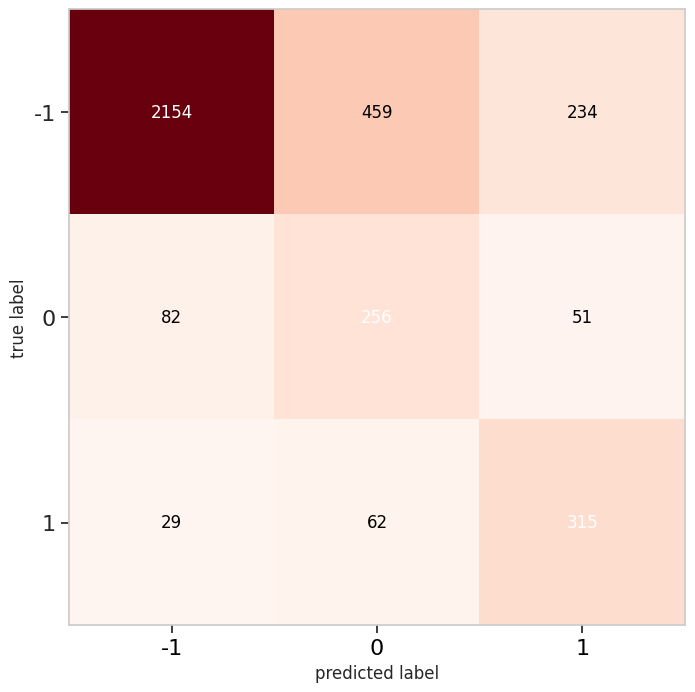

In [360]:
cm=confusion_matrix(y_pred_class , y_test)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Reds)
plt.xticks(range(3), [-1, 0, 1], fontsize=16,color='black')
plt.yticks(range(3), [-1, 0, 1], fontsize=16)
plt.show()

# **Saving The Model**

In [361]:
import joblib

# training the NB model and making predictions
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()

# fit
mnb.fit(X_train_transformed, y_train)

# predict class
y_pred_class = mnb.predict(X_test_transformed)

# predict probabilities
y_pred_proba = mnb.predict_proba(X_test_transformed)

# save the model to disk
joblib.dump(mnb, '/content/drive/MyDrive/Colab Notebooks/mnb_model_ad.pkl')

['/content/drive/MyDrive/Colab Notebooks/mnb_model_ad.pkl']

In [362]:
joblib.dump(vect, '/content/drive/MyDrive/Colab Notebooks/Vectorizer_ad.pkl')

['/content/drive/MyDrive/Colab Notebooks/Vectorizer_ad.pkl']

Model saved succesfully, moving to the load_prediction file